# 情感倾向分析

* 概述：本文基于7K条携程酒店评价数据为文本数据，将其导入到pytorch的模型架构然后进行训练出一个**可用于实际场所预测情感的模型**。

## 导入所需模块

In [1]:
# 导入所需模块
import torch 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import jieba 
import re
import os

D:\ana\envs\pytorch1.5\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 数据读取与预处理

In [2]:
# 正常显示中文标签
plt.rcParams["font.sans-serif"] = ["SimHei"]
# 正常显示负号
plt.rcParams["axes.unicode_minus"] = False

* 本文的数据来源于和鲸社区(https://www.kesci.com/)中携程网上七千条酒店评论数据(下文简称"酒店评论数据集")，该酒店评论数据集共有 7000 多条酒店评论数据，分为5000 多条正向评论和2000 多条负向评论。每一项酒店评价都被标记着"正面评价"或"负面评价"。酒店评论数据集的前5项数据如下所示：

In [3]:
# 读取数据
data = pd.read_csv("ChnSentiCorp_htl_all.csv")
# 查看数据的前5项
data.head()

,label,review
0,1,"距离川沙公路较近,但是公交指示不对,如果是""蔡陆线""的话,会非常麻烦.建议用别的路线.房间较..."
1,1,商务大床房，房间很大，床有2M宽，整体感觉经济实惠不错!
2,1,早餐太差，无论去多少人，那边也不加食品的。酒店应该重视一下这个问题了。房间本身很好。
3,1,宾馆在小街道上，不大好找，但还好北京热心同胞很多~宾馆设施跟介绍的差不多，房间很小，确实挺小...
4,1,"CBD中心,周围没什么店铺,说5星有点勉强.不知道为什么卫生间没有电吹风"


In [4]:
# 数据的形状
data.shape

(7766, 2)

In [5]:
# 查看重复数据
data.duplicated().sum()

0

数据共7766条。无重复数据(意味着接下来不需要对处理重复数据)

##  分词处理
*  首先，将评论内容转换为字符串，分词，正则匹配是基于字符串进行操作的

In [6]:
data["review"] = data["review"].astype('str')

In [7]:
# 去除标点符号和数字
# 要去除标点符号和数字，常用的办法就是使用正则表达式来处理，或者自行编写遍历替换函数

# 模式串
patten = r"[!\"#$%&'()*+,-./:;<=>?@[\\\]^_`{|}~—！，。？·￥、《》···【】：" "''\s0-9]+"  
re_obj = re.compile(patten)

# 替换函数--去除标点符号和数字
def clear(text):
    return re_obj.sub('', text)

# 将正则表达式替换函数应用于每一行
data["review"] = data["review"].apply(clear)
# 查看前5行替换结果

data["review"][:5]

0           距离川沙公路较近但是公交指示不对如果是蔡陆线的话会非常麻烦建议用别的路线房间较为简单
1                              商务大床房房间很大床有M宽整体感觉经济实惠不错
2                早餐太差无论去多少人那边也不加食品的酒店应该重视一下这个问题了房间本身很好
3    宾馆在小街道上不大好找但还好北京热心同胞很多宾馆设施跟介绍的差不多房间很小确实挺小但加上低价...
4                     CBD中心周围没什么店铺说星有点勉强不知道为什么卫生间没有电吹风
Name: review, dtype: object

* 采用精简处理，启用HMM(隐式马尔科夫网络)处理

In [8]:
def cut_words(words):
    return jieba.lcut(words) # 使用lcut分词

#apply函数对series的每一行数据进行处理
data["review"] = data["review"].apply(cut_words)
data["review"][:5]

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\m1824\AppData\Local\Temp\jieba.cache
Loading model cost 1.096 seconds.
Prefix dict has been built successfully.


0    [距离, 川沙, 公路, 较近, 但是, 公交, 指示, 不, 对, 如果, 是, 蔡陆线,...
1    [商务, 大床, 房, 房间, 很大, 床有, M, 宽, 整体, 感觉, 经济, 实惠, 不错]
2    [早餐, 太, 差, 无论, 去, 多少, 人, 那边, 也, 不加, 食品, 的, 酒店,...
3    [宾馆, 在, 小, 街道, 上, 不大好, 找, 但, 还好, 北京, 热心, 同胞, 很...
4    [CBD, 中心, 周围, 没什么, 店铺, 说星, 有点, 勉强, 不, 知道, 为什么,...
Name: review, dtype: object

## 停用词处理
* 选择中文停词表，来处理停用词，又由于本文讨论的背景为携程的酒店预订业务，故应当考虑将酒店、宾馆、携程这类作为业务背景常出现的词汇加入停用词处理范围，以发现更加具备业务本身价值的特征

In [9]:
# 使用 中文停用词表 
stop_words = "停用词汇总.txt"
stop_list = [
    i.strip() for i in open(stop_words, encoding='utf-8').readlines()
]  #读取停用词列表


def remove_stop(words):  #移除停用词函数
    texts = []

    for word in words:  # 遍历词列表里的每一个词
        if word not in stop_list:  # 若不在停用词列表中就将结果追加至texts列表中
            texts.append(word)

    return texts


data['review'] = data['review'].apply(remove_stop)
# 查看前5行
data["review"][:5]

0    [距离, 川沙, 公路, 较近, 公交, 指示, 蔡陆线, 非常, 麻烦, 建议, 路线, ...
1                      [商务, 大床, 房间, 床有, M, 整体, 经济, 实惠]
2                             [早餐, 不加, 食品, 酒店, 重视, 房间]
3    [宾馆, 街道, 不大好, 还好, 北京, 热心, 同胞, 宾馆, 设施, 介绍, 差不多,...
4                      [CBD, 中心, 店铺, 说星, 勉强, 卫生间, 电吹风]
Name: review, dtype: object

## 数据转换
* 上面处理结果得到的列表，不便于后续建模处理，可以将其转换为字符串

In [10]:
# 将列表元素转换为字符串
def list_str(content):
    return ' '.join(content)  #将列表元素转换为字符串


data['review'] = data['review'].apply(list_str)
# 将列表元素转换为字符串
data['review'][0]

'距离 川沙 公路 较近 公交 指示 蔡陆线 非常 麻烦 建议 路线 房间 较为简单'

## 样本均衡

In [11]:
# 正负样本的个数
data["label"].value_counts()

1    5322
0    2444
Name: label, dtype: int64

* 使用python中的matplotlib.pyplot模块绘制出该数据集正负样本的柱状图，如下图所示：

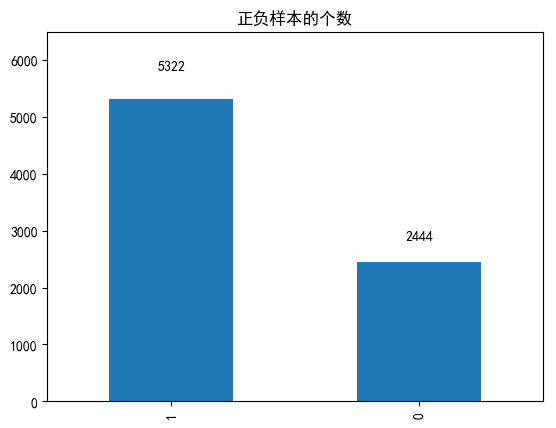

In [12]:
data["label"].value_counts().plot(kind = 'bar')
plt.text(0, 6000, str(data["label"].value_counts()[1]),
        ha = 'center', va = 'top')
plt.text(1, 3000, str(data["label"].value_counts()[0]),
        ha = 'center', va = 'top')
plt.ylim(0, 6500)
plt.title('正负样本的个数')
plt.show()

* 从柱状图可以看出，该数据集共7766条数据，其中正样本(label = 1)共有5322条，负样本(label = 0)共有2444条，没有重复数据

*  显然样本存在严重的不均衡问题，这里考虑两种样本均衡的策略
（1）欠采样，正负样本各2000条，一共4000条 
（2）过采样，正负样本各3000条，一共6000条

为减少计算量和对比两种均衡策略的效果，这里采用先把整体数据进行处理，再做样本均衡采样

In [13]:
def get_balanced_words(size,
                       positive_comment=data[data['label'] == 1],
                       negtive_comment=data[data['label'] == 0]):
    word_size = size // 2
    #获取正负评论数
    num_pos = positive_comment.shape[0]
    num_neg = negtive_comment.shape[0]
    #     当 正(负)品论数中<采样数量/2 时，进行上采样，否则都是下采样；
    #     其中pandas的sample方法里的repalce参数代表是否进行上采样，默认不进行
    balanced_words = pd.concat([
        positive_comment.sample(word_size,
                                replace=num_pos < word_size,
                                random_state=0),
        negtive_comment.sample(word_size,
                               replace=num_neg < word_size,
                               random_state=0)
    ])
    #     打印样本个数
    print('样本总数：', balanced_words.shape[0])
    print('正样本数：', balanced_words[data['label'] == 1].shape[0])
    print('负样本数：', balanced_words[data['label'] == 0].shape[0])
    print('')
    return balanced_words

In [14]:
# 欠采样
data_4000 = get_balanced_words(4000)

# 过采样
data_6000 = get_balanced_words(6000)

样本总数： 4000
正样本数： 2000
负样本数： 2000



D:\ana\envs\pytorch1.5\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
D:\ana\envs\pytorch1.5\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


样本总数： 6000
正样本数： 3000
负样本数： 3000



D:\ana\envs\pytorch1.5\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
D:\ana\envs\pytorch1.5\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [15]:
# 随机查看5行
data_4000.sample(5)

,label,review
3913,1,朋友 比莫泰 不好 没住 宾馆 反馈 年月日 感谢您 朋友 对本 酒店 认可 期待 光临
5739,0,最差 房间 高原 缺氧 房间 极易 加剧 高原 简陋 窗上 床垫 露出 木头 床架 洗手间 ...
6472,0,酒店 装修 气味 离开 酒店 记得 一串 西藏 天珠 遗漏 房间 小时 打电话 酒店 总台 ...
7179,0,房间 太旧 太吵 洗手间 热水 建议 携程 取消 合作 补充 点评 年月日 服务 态度恶劣 ...
555,1,环境 交通 便利 服务 下次 还会


In [16]:
data_6000.sample(5)

,label,review
7431,0,春节 入住 酒店 很差 四星级 服务 到位 我共住 五天 三天 服务员 房间 被子 一次性 ...
7757,0,房间 洗手间 房间 隔音 餐饮 服务 不好
245,1,酒店 位置 距离 火车站 非常 总提 酒店 性价比 房间 出公差
6269,0,宾馆 周边环境 隔墙 大型 公交 停车场 宾馆 长租 客人 房间 门上 信箱 怪怪的 房间 ...
7444,0,酒店 房间 设施 二星级 差不多 淋浴间 地上 黑点 东东 一次性 拖鞋 包装 一点点 还好...


## 数据切分--首先对欠样本进行建模
* 为了能够使用数据集进行深度学习，该数据集必须要有训练集，才能够训练模型之后进行预测或者识别文本中的情感、情绪、态度等。所以分别对数据集data_4000 进行数据切分，将其切分为训练集和测试集，并且用75\%做训练集，25\%做测试集


In [17]:
x_train_text, x_test_text, y_train, y_test = train_test_split(data_4000['review'],
                                                    data_4000['label'],
                                                    test_size = 0.25,
                                                    random_state=30,
                                                    shuffle=True)

In [18]:
# 查看形状
x_train_text.shape

(3000,)

In [19]:
# 查看形状
x_test_text.shape

(1000,)

## 建立token字典

因为深度学习模型只能接受数字，所以我们必须将"酒店评论文字"转换为"数字列表"。当要将一种语言翻译为另一种语言时，必须要有字典。相同的道理，要将文字转换为数字，也必须有字典。Keras提供了Tokenizer模块，就是类似字典的功能。建立token的方式为：
(1) 建立token时必须指定字典的字数，例如2000个字的字典。
(2) 读取训练数据4000或者6000项"酒店评论文字"，依照每一个中文词组在所有影评中出现的次数进行排序，前2000名的中文词组会列入字典中。
(3) 按照出现次数排序建立的自带你，所以可以说这是"酒店评论文字"的常用字典。
(4) 我们可以用这个字典进行转换，将中文转换为数字。

In [20]:
# 导入所需模块
import torch.nn.functional as F
import torchtext
from  torchtext import datasets,vocab

In [23]:
from torchtext.data import Field, NestedField, LabelField, TabularDataset, BucketIterator

In [24]:
def tokenizer(text):
    return jieba.cut(text)

word_field = Field(tokenize=tokenizer, lower=True, include_lengths=True, fix_length=32, tokenizer_language='en_core_web_sm')
label_field = Field(sequential=False, use_vocab=False)

In [20]:
fields = {
    'text': ('text_word', word_field),
    'label': ('label', label_field)
}
train, val = TabularDataset.splits(path='./data/THUCNews', train='train_demo.jsonl', validation='val_demo.jsonl', format='json', skip_header=True, fields=fields)
# train, val = TabularDataset.splits(path='./data/THUCNews', train='train_demo.tsv', validation='val_demo.tsv', format='tsv', skip_header=True, fields=fields)

print(train[5])
print(train[5].__dict__.keys())
print(train[5].text_word, train[5].label)
print()


In [55]:
# 建立token
token = Tokenizer(num_words = 2000)
token.fit_on_texts(x_train_text)

time: 163 ms


In [56]:
# 查看token读取了多少文章
print(token.document_count)

3000
time: 468 µs


In [60]:
# 查看token.word_index属性
print(token.word_index)

{'房间': 1, '很': 2, '不': 3, '都': 4, '还': 5, '服务': 6, '住': 7, '不错': 8, '好': 9, '入住': 10, '说': 11, '去': 12, '前台': 13, '感觉': 14, '早餐': 15, '一个': 16, '服务员': 17, '人': 18, '设施': 19, '价格': 20, '）': 21, '客人': 22, '（': 23, '晚上': 24, '上': 25, '没': 26, '；': 27, '才': 28, '差': 29, '环境': 30, '后': 31, '时': 32, '小': 33, '里': 34, '会': 35, '房': 36, '年月日': 37, '元': 38, '太': 39, '再': 40, '干净': 41, '大': 42, '下次': 43, '不好': 44, '点': 45, '点评': 46, '居然': 47, '装修': 48, '这家': 49, '免费': 50, '卫生间': 51, '地方': 52, '实在': 53, '态度': 54, '吃': 55, '大堂': 56, '位置': 57, '很多': 58, '发现': 59, '餐厅': 60, '选择': 61, '建议': 62, '空调': 63, '看': 64, '一点': 65, '退房': 66, '竟然': 67, '最': 68, '想': 69, '交通': 70, '特别': 71, '补充': 72, '隔音': 73, '性价比': 74, '电话': 75, '预定': 76, '大床': 77, '第二天': 78, '标准': 79, '订': 80, '总体': 81, '时间': 82, '希望': 83, '朋友': 84, '推荐': 85, '提供': 86, '月': 87, '日': 88, '打电话': 89, '人员': 90, '算': 91, '走': 92, '找': 93, '舒服': 94, '…': 95, '楼': 96, '味道': 97, '问': 98, '反馈': 99, '满意': 100, '分钟': 101, '客房': 102, '高': 103, '真的': 104

In [61]:
# 使用tokne将review转换为数字列表
x_train_seq = token.texts_to_sequences(x_train_text)
x_test_seq = token.texts_to_sequences(x_test_text)

time: 138 ms


In [62]:
# 查看转换为sequences之后的结果
print(x_train_seq[0])

[160, 29, 492, 1849, 22, 4, 6, 3, 573, 177, 79]
time: 480 µs


可以看到训练数据的"评论文字"已经转换为"数字列表"，并且从查看第0项的"数字列表"可以发现前3个文字转换成为了160、29、492。

## 固定数字长度
* 因为每一则的"酒店评论"的词数都不固定，列入有些可能有26个词组，有些是10个词组。转换成"数字列表"的数字个数也就不固定。因为后续要将"数字列表"转换为"向量列表"，并送入到深度学习模型进行训练，所以长度必须固定。使用截长补短的方法让转换后的数字长度相同。

In [64]:
# 让转换后的数字长度相同
# 截长补短
x_train = sequence.pad_sequences(x_train_seq, maxlen = 50)
x_test = sequence.pad_sequences(x_test_seq, maxlen = 50)

time: 24.1 ms


In [65]:
# 查看统一长度后的数字列表
print('before pad_sequences length =', len(x_train_seq[4]))
print(x_train_seq[0])

before pad_sequences length = 23
[160, 29, 492, 1849, 22, 4, 6, 3, 573, 177, 79]
time: 639 µs


In [66]:
print('after pad_sequences length = ', len(x_train[0]))
print(x_train[0])

after pad_sequences length =  50
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0  160   29  492
 1849   22    4    6    3  573  177   79]
time: 960 µs


* 使用嵌入层将"数字列表"转换为"向量列表"。词嵌入是一种自然语言处理技术，其原理是将文字映射成多维几何空间的向量。语义类似的文字向量在多维的几何空间的距离也比较相近。前面我们将"评论"转换为数字，可是数字在语义上无任何关联。为了能让每一个文字都有关联性，必须转换为向量的形式。Keras提供了嵌入层可以用于将"数字列表"转换为"向量列表"。该过程会在建立深度学习模型的过程中一起加入嵌入层。

以上数据预处理完成后产生欠采样的训练数据与测试数据，还有过采样的训练数据与测试数据。训练数据将送入各种深度学习模型进行训练，而测试数据可以用于评估深度学习模型的准确率，并进行预测。

## 欠采样模型的建立——建立多层感知器模型进行情感分析

In [67]:
# 加入嵌入层
# 导入所需模块
from keras.models import Sequential 
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.embeddings import Embedding

time: 604 µs


In [68]:
# 建立模型
# 建立一个线性堆叠模型，后续只需要将各个神经网络加入模型即可
model = Sequential()

time: 20.2 ms


In [69]:
# 将嵌入层加入模型
model.add(Embedding(output_dim = 32,
                    input_dim = 2000,
                    input_length = 50))
model.add(Dropout(0.2))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
time: 35.2 ms


In [70]:
# 建立多层感知器模型进行情感分析
# 将平坦层加入模型
model.add(Flatten())

time: 8.48 ms


In [71]:
# 将隐藏层加入模型
model.add(Dense(units = 256,
                activation = 'relu'))
model.add(Dropout(0.35))

time: 24 ms


In [72]:
# 将输出层加入模型
model.add(Dense(units = 1,
                activation = 'sigmoid'))

time: 12 ms


In [73]:
# 查看模型摘要
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 32)            64000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               409856    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 474,113
Trainable params: 474,113
Non-trainable params: 0
_________________________________________________________________
time

* 可以看到共有四层：平坦层共有1600个神经元，平坦层在这里可以看作为输入层。隐藏层共有256个神经；输出层只有1个神经元。全部必须训练的超参数有474113个，通常超参数数值越大，代表此模型越复杂，需要更多时间进行训练。

In [74]:
# 训练模型
# 定义训练方式
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

time: 33.5 ms


In [75]:
# 开始训练
train_history = model.fit(x_train, y_train, batch_size = 100,
                          epochs = 10, verbose = 2,
                          validation_split = 0.2)

Instructions for updating:
Use tf.cast instead.
Train on 2400 samples, validate on 600 samples
Epoch 1/10
 - 1s - loss: 0.6877 - acc: 0.5508 - val_loss: 0.6719 - val_acc: 0.6217
Epoch 2/10
 - 0s - loss: 0.6283 - acc: 0.6946 - val_loss: 0.5797 - val_acc: 0.7400
Epoch 3/10
 - 0s - loss: 0.4242 - acc: 0.8462 - val_loss: 0.4089 - val_acc: 0.8183
Epoch 4/10
 - 0s - loss: 0.2365 - acc: 0.9133 - val_loss: 0.3808 - val_acc: 0.8333
Epoch 5/10
 - 0s - loss: 0.1287 - acc: 0.9642 - val_loss: 0.3934 - val_acc: 0.8417
Epoch 6/10
 - 0s - loss: 0.0750 - acc: 0.9821 - val_loss: 0.4435 - val_acc: 0.8300
Epoch 7/10
 - 0s - loss: 0.0469 - acc: 0.9904 - val_loss: 0.4470 - val_acc: 0.8383
Epoch 8/10
 - 0s - loss: 0.0305 - acc: 0.9950 - val_loss: 0.4715 - val_acc: 0.8283
Epoch 9/10
 - 0s - loss: 0.0214 - acc: 0.9958 - val_loss: 0.4906 - val_acc: 0.8233
Epoch 10/10
 - 0s - loss: 0.0168 - acc: 0.9975 - val_loss: 0.5269 - val_acc: 0.8283
time: 5.69 s


* 从以上执行结果可知，共执行了10个训练周期，并可以发现误差越来越小，准确率越来越高。

## 准确率与误差的执行结果

In [78]:
# 评估模型准确率
scores = model.evaluate(x_test, y_test, verbose = 1)
print('accuracy = ', scores[1])

1000/1000 [==============================] - 0s 24us/step
accuracy =  0.803
time: 25.8 ms


In [79]:
# 建立show_train_history显示训练过程
import matplotlib.pyplot as plt
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc = 'upper left')
    plt.show()

time: 936 µs


<Figure size 432x288 with 1 Axes>
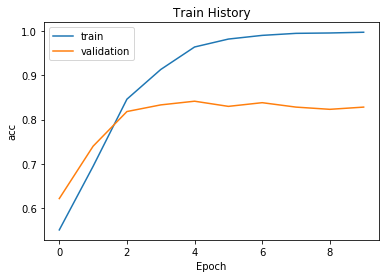

time: 129 ms


In [82]:
# 画出准确率执行结果
show_train_history(train_history, 'acc', 'val_acc')

* 从上图可以看出，"acc训练的准确率"为蓝色的，"val_acc验证的准确率"是黄色的。我们可以发现：无论是在训练还是验证，准确率都越来越高；不过在epoch训练后期，"acc训练的准确率"比"val_acc验证的准确率"高。如果"acc训练的准确率"一直增加，但"val_acc验证的准确率"一直没有增加，可能出现了过度拟合的现象。

<Figure size 432x288 with 1 Axes>
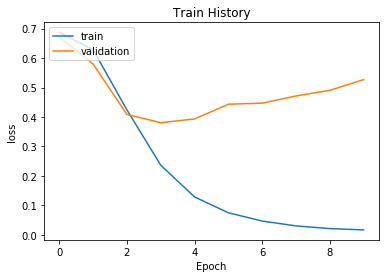

time: 135 ms


In [83]:
# 画出误差执行结果
show_train_history(train_history, 'loss', 'val_loss')

* 从图可以看出，"loss训练的误差"是蓝色；"val_loss"验证的误差是黄色。共执行了10个训练周期，我们发现：无论是训练还是验证，验证的误差都越来越低。在Epoch训练后期，"loss训练的误差"比"val_loss"小。

In [84]:
# 执行预测
predict = model.predict_classes(x_test)

time: 56.2 ms


In [85]:
# 预测结果
# 查看预测结果的前10项数据
predict[:10]

array([[1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0]], dtype=int32)

time: 1.81 ms


In [86]:
# 使用一维数组查看预测结果
predict_classes = predict.reshape(-1)
predict_classes[:10]

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 0], dtype=int32)

time: 1.83 ms


In [87]:
# 查看测试数据预测结果
# 之前的预测结果是0与1，显示负面评价或正面评价
SentimentDict = {1:'正面评价', 0:'负面评价'}
# 显示标号5020的预测结果
print(x_test_text[5020])
print('review真实值：',SentimentDict[y_test[5020]],
      '预测结果：', SentimentDict[predict_classes[1]])

很 好 起码 四星 服务 人员 经理 态度 好 早餐 行 性价比 满意 反馈 年月日 感谢您 光临 鼓励 工作 动力 真诚 期待 再次 光临
review真实值： 正面评价 预测结果： 正面评价
time: 1.43 ms


In [88]:
# 显示标签1563的预测结果
print(x_test_text[1563])
print('review真实值：',SentimentDict[y_test[1563]],
      '预测结果：', SentimentDict[predict_classes[5]])

赞 性价比 极高 下次 还会 选择
review真实值： 正面评价 预测结果： 正面评价
time: 1.11 ms


* 如果想要进一步知道在所建立的模型中预测准确率的高低，就可以使用混淆矩阵(confusion matrix)来显示。在机器学习领域中，特别是统计分类的问题，混淆矩阵也称为误差矩阵，是一种特定的表格显示方式，可以让我们以可视化的方式了解有监督的学习算法的结果，看出算法模型是否混淆了两个类(将某一个标签预测成另一个标签)。

In [89]:
# 显示混淆矩阵
# 使用pandas crosstab建立混淆矩阵
pd.crosstab(y_test, predict_classes,
            rownames = ['label'], colnames = ['predict'])

predict,0,1
label,,
0,397,123
1,74,406


time: 17.3 ms


* 从混淆矩阵中我们观察得到的结果如下：对象线是预测正确的数字，我们发现：真实值是"1"，被正确预测为"1"的项数有406项，预测准确率高。而真实值为"0"，被正确预测为"0"的项数有397项，准确率最高。其他非对角线的数字代表将某一个标签预测错误，成为另一个标签。

In [90]:
# 线上选取携程酒店--珠海亦方美学公寓--的酒店评价文字进行预测
input_text = """
去之前会有担心，因为疫情，专门打了电话给前台，前台小哥哥好评，耐心回答，打消了我的顾虑，nice!! 
看得出有做好防疫情清洁消毒工作，前台登记反复询问，确保出行轨迹安全，体温测量登记，入住好评，选了主题房，设计是我喜欢的.
总之下次有需要还是会自住或推荐!!
"""

time: 423 µs


In [91]:
# 执行预测
# 数据预处理

# 去词处理
input_text = clear(input_text)
# 分词处理
input_text = cut_words(input_text)
# 停词处理
input_text = remove_stop(input_text)
# 将列表元素转换为字符串
input_text = list_str(input_text)

time: 2.48 ms


In [92]:
# 将酒店评价转换为数字列表
input_seq = token.texts_to_sequences([input_text])

time: 504 µs


In [93]:
# 查看数字列表
print(input_seq)

# 查看数字列表的长度
len(input_seq[0])

[[12, 35, 1317, 75, 13, 13, 33, 1073, 396, 1316, 663, 225, 13, 352, 365, 459, 352, 10, 9, 36, 475, 173, 43, 35, 85]]


25

time: 2.16 ms


In [94]:
# 截取数字列表使其长度为50
pad_input_seq = sequence.pad_sequences(input_seq, maxlen = 50)

time: 526 µs


In [95]:
# 截长补短后查看数字列表的长度
len(pad_input_seq[0])

50

time: 1.66 ms


In [96]:
# 使用多层感知器模型进行预测
predict_result = model.predict_classes(pad_input_seq)

time: 1.29 ms


In [97]:
# 查看预测结果
predict_result[0][0]

1

time: 1.65 ms


In [98]:
# 使用之前定义的SentimentDic字典将结果1转换为文字
SentimentDict[predict_result[0][0]]

'正面评价'

time: 1.61 ms


In [99]:
# 创建predict_review()函数，将前面的函数命令全部整理成自定义函数
def predict_review(input_text):
    input_text = clear(input_text)
    input_text = cut_words(input_text)
    input_text = remove_stop(input_text)
    input_text = list_str(input_text)
    input_seq = token.texts_to_sequences([input_text])
    pad_input_seq = sequence.pad_sequences(input_seq, maxlen = 50)
    predict_result = model.predict_classes(pad_input_seq)
    print(SentimentDict[predict_result[0][0]])

time: 933 µs


In [100]:
# 重新选取线上酒店评价
input_text = """
去之前会有担心，因为疫情，专门打了电话给前台，前台小哥哥好评，耐心回答，打消了我的顾虑，nice!! 
看得出有做好防疫情清洁消毒工作，前台登记反复询问，确保出行轨迹安全，体温测量登记，入住好评，选了主题房，设计是我喜欢的.
总之下次有需要还是会自住或推荐!!
"""

predict_review(input_text)

正面评价
time: 3.55 ms


至此，对携程酒店评价的情感倾向分析，以建立一个简单的多层感知器模型结束，由于文章所限，后续的模型优化以及与其他深度学习的模型的比较就不进行简述，有兴趣的读者可以留意本人的下次项目创建。谢谢大家！